In [36]:
# --- Core Libraries ---
import os
import random
import pickle
from collections import OrderedDict
import copy

# --- Numerical and Scientific Libraries ---
import numpy as np
from scipy.ndimage import gaussian_filter

# --- Machine Learning and Deep Learning ---
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
from sklearn.metrics import roc_auc_score, roc_curve

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

# --- Custom Dataloader ---
# Make sure your bowtie.py file is in a folder named 'datasets'
import datasets.bowtie as bowtie

# --- Utils / shared helpers ---
from utils.helpers import (
    get_batch_embeddings,
    denormalize_image_for_display,
    concatenate_embeddings,
    plot_individual_visualizations
)

import cv2

# --- Device Configuration ---
IS_CUDA_AVAILABLE = torch.cuda.is_available()
DEVICE = torch.device('cuda' if IS_CUDA_AVAILABLE else 'cpu')
print(f"--- Running on device: {DEVICE} ---")

--- Running on device: cuda ---


In [2]:
# --- Computation Flags ---
# When True the two-pass stats (mean/cov) will be computed on the GPU (may OOM)
STATS_ON_GPU = False
# When True the Mahalanobis scoring will happen on the GPU (may OOM)
MAHALANOBIS_ON_GPU = True

Good practice in notebooks is to keep all your main parameters in one place. This makes it easy to experiment with different settings without hunting through the code.

In [3]:
# --- Model & Feature Parameters ---
# The pre-trained network architecture to use.
# 'wide_resnet50_2' is generally more powerful but slower. 'resnet18' is faster.
MODEL_ARCHITECTURE = "wide_resnet50_2"
# These dimensions are specific to the chosen architecture.
# TOTAL_FEATURE_DIMENSION: The combined number of channels from the layers we extract.
# REDUCED_FEATURE_DIMENSION: The number of random features we select to model.
if MODEL_ARCHITECTURE == "wide_resnet50_2":
    TOTAL_FEATURE_DIMENSION = 1792
    REDUCED_FEATURE_DIMENSION = 550
else: # resnet18
    TOTAL_FEATURE_DIMENSION = 448
    REDUCED_FEATURE_DIMENSION = 100

# --- Dataset & Path Parameters ---
# The specific class within your dataset to train and test on.
CLASS_NAME = "color_profile_1"
# Root path to your dataset.
DATA_PATH = "../anomaly_detection/data/BowTie-New/color_profile_1"
# Directory where all results, cached files, and images will be saved.
BASE_RESULTS_DIR = "./results"

is_direct_class_folder = os.path.isdir(
    os.path.join(DATA_PATH, "train")
) and os.path.isdir(os.path.join(DATA_PATH, "test"))

if is_direct_class_folder:
    class_name = os.path.basename(os.path.abspath(DATA_PATH))
    print(
        f"Data path appears to be a single class folder. Running for class: {class_name}"
    )
    # BowtieDataManager expects dataset_path to be the parent folder that
    # contains class subfolders; when data_path already points to class
    # folder, set data_path to its parent and pass the class folder name.
    DATA_PATH = os.path.dirname(os.path.abspath(DATA_PATH))
    

# --- Image Preprocessing Parameters ---
# The size images are resized to before being cropped.
RESIZE = 256
# The final size of the image fed into the model. Must match model's expected input.
CROPSIZE = RESIZE

# --- Reproducibility ---
# Setting a seed ensures you get the same 'random' results every time you run the code.
RANDOM_SEED = 1024

# Create a unique name for this experiment run
experiment_name = f"{MODEL_ARCHITECTURE}_resize-{RESIZE}_crop-{CROPSIZE}"

# Define the master directory for this experiment
MASTER_SAVE_DIR = os.path.join(BASE_RESULTS_DIR, experiment_name)

# Define the specific directory for the current class
CLASS_SAVE_DIR = os.path.join(MASTER_SAVE_DIR, CLASS_NAME)

# Create the directories if they don't exist
os.makedirs(CLASS_SAVE_DIR, exist_ok=True)

print(f"All results for this run will be saved in: {MASTER_SAVE_DIR}")
print(f"Results for class '{CLASS_NAME}' will be in: {CLASS_SAVE_DIR}")

Data path appears to be a single class folder. Running for class: color_profile_1
All results for this run will be saved in: ./results/wide_resnet50_2_resize-256_crop-256
Results for class 'color_profile_1' will be in: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1


These are utility functions that we'll use throughout the notebook. They handle tasks like plotting results and combining feature maps.

The **embedding_concat** function is particularly important.

Our ResNet model produces feature maps of different spatial sizes at different layers (e.g., Layer 1 might be 100x100, Layer 2 is 50x50). To combine them, we can't just stack them. This function uses a clever method to align and concatenate them into a single, rich feature vector for every location.

In [4]:
# Using shared helper implementations from utils.helpers:
# - denormalize_image_for_display
# - concatenate_embeddings
# The local implementations were removed to ensure we use the canonical, tested helpers.

Here, we load our pre-trained ResNet model. We are not training the model itself; instead, we are using it as a powerful, off-the-shelf **feature extractor**.

To get the rich, multi-level features PaDiM needs, we use **PyTorch Hooks**. A hook is like a little spy we can attach to any layer in the network. When the model processes an image, our hook will automatically grab the output of that layer for us without interrupting the flow. We are attaching hooks to the end of layers 1, 2, and 3.

In [5]:
# --- Load Pre-trained Model ---
print(f"Loading pre-trained model: {MODEL_ARCHITECTURE}")
if MODEL_ARCHITECTURE == "wide_resnet50_2":
    model = wide_resnet50_2(weights="DEFAULT")
else:
    model = resnet18(weights="DEFAULT")

model.to(DEVICE)
model.eval()  # Set the model to evaluation mode (crucial!)

# --- Set Seeds for Reproducibility ---
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if IS_CUDA_AVAILABLE:
    torch.cuda.manual_seed_all(RANDOM_SEED)

# --- Random Feature Selection ---
# PaDiM randomly selects a subset of the feature channels to model.
# This reduces memory and computation while maintaining high performance.
print(f"Randomly selecting {REDUCED_FEATURE_DIMENSION} features from a total of {TOTAL_FEATURE_DIMENSION}.")
random_feature_indices = torch.tensor(
    random.sample(range(0, TOTAL_FEATURE_DIMENSION), REDUCED_FEATURE_DIMENSION)
)

# --- Setup Hooks to Extract Intermediate Features ---
# This list will store the feature maps captured by our hooks.
intermediate_feature_maps = []
def hook_function(module, input, output):
    """A simple hook that appends the output of a layer to a list."""
    intermediate_feature_maps.append(output)

# Register the hook function on the final block of the first three layers.
model.layer1[-1].register_forward_hook(hook_function)
model.layer2[-1].register_forward_hook(hook_function)
model.layer3[-1].register_forward_hook(hook_function)

Loading pre-trained model: wide_resnet50_2
Randomly selecting 550 features from a total of 1792.


Now we'll prepare our datasets. We create two instances of our **BowtieDataset**: one for training (containing only normal images) and one for testing (containing a mix of normal and abnormal images). The **DataLoader** then wraps these datasets to efficiently feed batches of images to the model.

In [6]:
# --- Create the Data Manager and DataLoaders ---
print("Initializing the Bowtie Data Manager...")

# Initialize the manager once. It handles all the splitting internally.
data_manager = bowtie.BowtieDataManager(
    dataset_path=DATA_PATH,
    class_name=CLASS_NAME,
    resize=RESIZE,
    cropsize=CROPSIZE,
    augmentations_enabled=False,
    horizontal_flip=False,
    vertical_flip=False,
    augmentation_prob=0.5,
    seed=RANDOM_SEED
)

# Create DataLoaders directly from the manager's attributes
train_dataloader = DataLoader(data_manager.train, batch_size=32, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(data_manager.test, batch_size=32, pin_memory=True)

Initializing the Bowtie Data Manager...


In [7]:
data_manager.print_dataset_summary()

--- Bowtie Dataset Summary ---
Dataset path (root): /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train
Total images discovered (train+test): 408
 - Train images: 300
 - Test images:  108 (Normal: 75, Abnormal: 33)

Training augmentation settings:
 - Augmentations enabled: False
 - Horizontal flip:      False
 - Vertical flip:        False
 - Augmentation prob:    0.5
-------------------------------


In [8]:
data_manager.print_train_files()

File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_078.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_123.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_117.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_071.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/27952J_035.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/27952J_011.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_103.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_070.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New

In [9]:
data_manager.print_test_files()

File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/27952J_016.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/121_124.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/27952J_084.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/27952J_100.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/121_048.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/27952J_065.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_021.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowTie-New/color_profile_1/train/good/120_114.jpg, Label: 0
File: /home/mikeszklarz/dev/lanl/anomaly_detection/data/BowT

This is the core training step of PaDiM. We will process all normal images from the train_dataloader and perform the following actions:

1. **Extract Features**: Pass each image through the ResNet model. Our hooks will capture the feature maps from layers 1, 2, and 3.

2. **Concatenate & Reduce**: Combine the feature maps using our concatenate_embeddings function and then select the random subset of channels we chose earlier.

3. **Calculate Statistics**: For each patch location in the feature map, we compute the mean and covariance across all training images. This collection of means and covariances is our learned model of normalcy.

4. **Cache Results**: We save this statistical model to a .pkl file so we don't have to re-compute it every time we run the notebook.

In [10]:
# --- Learn the Distribution of Normal Features (two-pass, tensorized) ---

# Path for the cached statistical model in the class-specific directory
learned_distribution_path = os.path.join(CLASS_SAVE_DIR, 'learned_distribution.pkl')

compute_device = DEVICE if (STATS_ON_GPU and DEVICE.type == 'cuda') else torch.device('cpu')
print(f"Mean/Covariance compute device: {compute_device}")

if not os.path.exists(learned_distribution_path):
    print("No cached distribution found. Learning from scratch (two-pass)...")

    model.eval()
    total_samples = 0
    sum_of_features = None
    c = h = w = None

    # PASS 1: accumulate sum to compute mean
    for image_batch, _, _ in tqdm(train_dataloader, desc="Pass 1: mean accumulation"):
        with torch.no_grad():
            batch_embeddings = get_batch_embeddings(
                image_batch, intermediate_feature_maps, random_feature_indices, model, DEVICE, compute_device
            )  # returns tensor on compute_device shaped (B, C, H, W)

        b, c, h, w = batch_embeddings.shape
        batch_embeddings = batch_embeddings.view(b, c, h * w)  # (B, C, P)
        if sum_of_features is None:
            sum_of_features = torch.zeros(c, h * w, dtype=torch.float32, device=compute_device)
        sum_of_features += torch.sum(batch_embeddings, dim=0)
        total_samples += b

    mean_vectors = sum_of_features / total_samples  # shape (C, P)
    print(f"Pass 1 complete. Mean shape: {mean_vectors.shape}; total samples: {total_samples}")

    # PASS 2: accumulate outer-products to compute covariance per patch
    sum_of_outer = torch.zeros(c, c, h * w, dtype=torch.float32, device=compute_device)
    for image_batch, _, _ in tqdm(train_dataloader, desc="Pass 2: covariance accumulation"):
        with torch.no_grad():
            batch_embeddings = get_batch_embeddings(
                image_batch, intermediate_feature_maps, random_feature_indices, model, DEVICE, compute_device
            )  # (B, C, H, W)

        b, c, h, w = batch_embeddings.shape
        batch_embeddings = batch_embeddings.view(b, c, h * w)  # (B, C, P)
        centered = batch_embeddings - mean_vectors.unsqueeze(0)  # (B, C, P)
        # permute to (B, P, C) then einsum over batch: 'bpc,bpd->pcd' -> (P,C,C)
        outer_sum = torch.einsum("bpc,bpd->pcd", centered.permute(0, 2, 1), centered.permute(0, 2, 1))
        # convert to (C,C,P) to match prior shapes
        sum_of_outer += outer_sum.permute(1, 2, 0)

    cov_matrices = sum_of_outer / (total_samples - 1)  # (C,C,P)
    # regularize
    identity = torch.eye(c, device=compute_device).unsqueeze(2).expand(-1, -1, h * w)
    cov_matrices += 0.01 * identity

    learned_distribution = [mean_vectors.cpu().numpy(), cov_matrices.cpu().numpy()]
    print("Learning complete. Saving distribution...")
    with open(learned_distribution_path, "wb") as f:
        pickle.dump(learned_distribution, f)
else:
    print(f"Loading cached distribution from: {learned_distribution_path}")
    with open(learned_distribution_path, 'rb') as f:
        learned_distribution = pickle.load(f)
print("--- Learning of 'normal' distribution complete. ---")

Mean/Covariance compute device: cpu
No cached distribution found. Learning from scratch (two-pass)...


Pass 1: mean accumulation: 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Pass 1 complete. Mean shape: torch.Size([550, 4096]); total samples: 300


Pass 2: covariance accumulation: 100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


Learning complete. Saving distribution...
--- Learning of 'normal' distribution complete. ---


What does a neural network "see"? A feature map is the output of a network layer. You can think of each channel in the feature map as a filter that has learned to detect a specific pattern (an edge, a curve, a texture). Here, we'll run a single image through the model and visualize the first few channels from each layer's feature map.

After processing all the normal training images, we calculated a **mean_vectors** array. This represents the "average" or "ideal" feature for every single patch location. By reshaping it back into an image-like format, we can visualize this "blueprint of normalcy."


--- Visualization 4: The Learned 'Normal' Mean Feature Map ---
Mean array shape: (550, 4096)


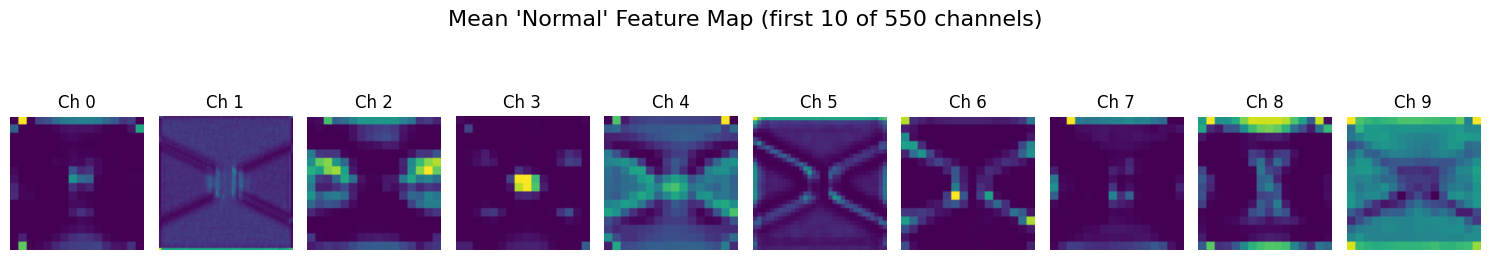

In [11]:
# --- 4. Visualize the Learned 'Normal' Mean ---
print("\n--- Visualization 4: The Learned 'Normal' Mean Feature Map ---")

# The learned_distribution contains [mean, covariance]
mean_features = learned_distribution[0] # Shape [Channels, Height*Width] e.g., [550, 1600]
num_channels, num_patches = mean_features.shape
patch_dim = int(np.sqrt(num_patches))
print(f"Mean array shape: {mean_features.shape}")

# Reshape to be plottable: [Channels, Height, Width]
mean_features_map = mean_features.reshape(num_channels, patch_dim, patch_dim)

# Plot a few channels of the mean feature map
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
fig.suptitle(f"Mean 'Normal' Feature Map (first 10 of {num_channels} channels)", fontsize=16)
for i in range(10):
    axes[i].imshow(mean_features_map[i], cmap='viridis')
    axes[i].set_title(f'Ch {i}')
    axes[i].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

The covariance matrix tells us how different features are related to each other for a single patch. A high value means two features tend to increase or decrease together (e.g., a "vertical edge" feature and a "shadow" feature might be correlated). The Mahalanobis distance uses this information to make a smarter comparison. We will visualize the covariance matrix for the patch at the very center of the image.

Now that we have our model of normalcy, we can score our test images. The process is similar to the training stage, but instead of calculating statistics, we measure deviation.

1. **Extract Test Features**: Pass each test image through the model to get its feature embeddings.

2. **Calculate Mahalanobis Distance**: For each patch in the test image's feature map, we calculate its Mahalanobis distance to the corresponding learned "normal" distribution. A large distance means the patch is "far" from normal and thus anomalous.
**Why Mahalanobis Distance?** Unlike standard Euclidean distance, Mahalanobis distance accounts for the correlation between features. If two features normally vary together, it won't penalize them, making it much more robust for this task.

3. **Create Anomaly Map**: The distances for all patches form a low-resolution anomaly map. We then use bilinear interpolation to resize it to the original image size and apply a Gaussian filter to smooth the results.

In [12]:
# --- Extract Features from the Test Set and Compute Mahalanobis Distances (vectorized) ---
print("Extracting features from the test set and computing Mahalanobis distances...")

eval_device = DEVICE if (MAHALANOBIS_ON_GPU and DEVICE.type == 'cuda') else torch.device('cpu')
print(f"Mahalanobis compute device: {eval_device}")

test_images_list = []
ground_truth_labels = []
all_distances = []

# Move learned stats to eval device and make shapes compatible
mean_t = torch.tensor(learned_distribution[0], dtype=torch.float32, device=eval_device)  # (C, P)
cov_t = torch.tensor(learned_distribution[1], dtype=torch.float32, device=eval_device)   # (C, C, P)
# invert covariances per patch: cov_inv shape (P, C, C)
cov_inv_t = torch.linalg.inv(cov_t.permute(2, 0, 1)).to(eval_device)  # (P, C, C)
# permute mean to shape (P, C)
mean_t = mean_t.permute(1, 0)  # (P, C)

model.eval()
for image_batch, labels, _ in tqdm(test_dataloader, desc="Eval: embeddings -> distances"):
    test_images_list.extend(image_batch.cpu().numpy())
    ground_truth_labels.extend(labels.cpu().numpy())

    with torch.no_grad():
        batch_embeddings = get_batch_embeddings(
            image_batch, intermediate_feature_maps, random_feature_indices, model, DEVICE, eval_device
        )  # (B, C, H, W) on eval_device

    b, c, h, w = batch_embeddings.shape
    batch_embeddings = batch_embeddings.view(b, c, h * w).permute(0, 2, 1)  # (B, P, C)
    # broadcasted diff: (B, P, C) - (P, C) -> (B, P, C)
    diff = batch_embeddings - mean_t.unsqueeze(0)
    # compute dist^2 via einsum: 'bpc,pcd,bpd->bp' (use cov_inv_t shape (P,C,C))
    tmp = torch.einsum("bpc,pcd->bpd", diff, cov_inv_t)
    dist_sq = torch.sum(tmp * diff, dim=2)
    dist = torch.sqrt(dist_sq)
    all_distances.append(dist.cpu().numpy())

distances = np.concatenate(all_distances, axis=0)  # (N_test, P)
anomaly_maps_raw = distances.reshape(len(test_images_list), h, w)

# Upsample and smooth as before
score_maps = F.interpolate(
    torch.tensor(anomaly_maps_raw).unsqueeze(1),
    size=CROPSIZE,
    mode="bilinear",
    align_corners=False,
).squeeze().numpy()

for i in range(score_maps.shape[0]):
    score_maps[i] = gaussian_filter(score_maps[i], sigma=4)

print("--- Anomaly score generation complete. ---")

Extracting features from the test set and computing Mahalanobis distances...
Mahalanobis compute device: cuda


Eval: embeddings -> distances: 100%|██████████| 4/4 [00:10<00:00,  2.56s/it]

--- Anomaly score generation complete. ---


Finally, we evaluate our model's performance.

1. **Normalize Scores**: We normalize the anomaly maps to a 0-1 range for consistency.

2. **Image-Level Score**: The final anomaly score for an entire image is taken as the maximum score from its anomaly map.

3. **ROC AUC Score**: We use the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) to measure performance. An AUC of 1.0 is a perfect classifier, while 0.5 is no better than random guessing.

We will then plot the ROC curve and save visualizations of the heatmap overlays for each test image.

In [13]:
# --- Normalize Scores ---
max_score = score_maps.max()
min_score = score_maps.min()
normalized_scores = (score_maps - min_score) / (max_score - min_score)

# --- Calculate Image-Level Scores and ROC AUC ---
image_level_anomaly_scores = normalized_scores.reshape(normalized_scores.shape[0], -1).max(axis=1)
ground_truth_labels = np.asarray(ground_truth_labels)
false_positive_rate, true_positive_rate, _ = roc_curve(ground_truth_labels, image_level_anomaly_scores)
image_roc_auc = roc_auc_score(ground_truth_labels, image_level_anomaly_scores)

Image-level ROC AUC for class 'color_profile_1': 0.941
AUROC score saved to: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1/results.txt
ROC curve plot saved to: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1/roc_curve.png


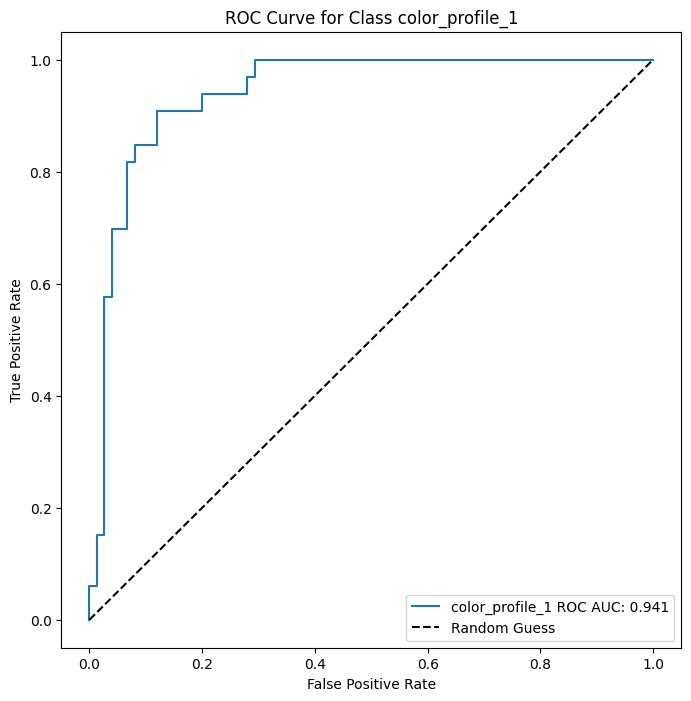

Score distribution plot saved to: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1/score_distribution.png


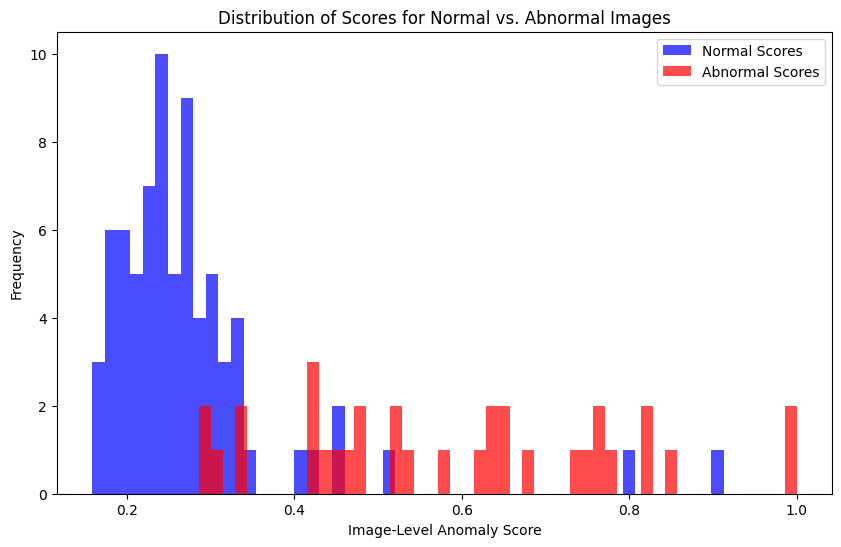

In [14]:
print(f"Image-level ROC AUC for class '{CLASS_NAME}': {image_roc_auc:.3f}")

# --- Save the AUROC score to a text file ---
results_filepath = os.path.join(CLASS_SAVE_DIR, 'results.txt')
with open(results_filepath, 'w') as f:
    f.write(f"Image-level ROC AUC: {image_roc_auc:.4f}\n")
print(f"AUROC score saved to: {results_filepath}")


# --- Create, Save, and Display the ROC Curve Plot ---
roc_curve_fig = plt.figure(figsize=(8, 8))
plt.plot(false_positive_rate, true_positive_rate, label=f'{CLASS_NAME} ROC AUC: {image_roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for Class {CLASS_NAME}')
plt.legend(loc='lower right')
roc_curve_path = os.path.join(CLASS_SAVE_DIR, 'roc_curve.png')
roc_curve_fig.savefig(roc_curve_path)
print(f"ROC curve plot saved to: {roc_curve_path}")
plt.show()


# --- Create, Save, and Display the Score Distribution Plot ---
score_dist_fig = plt.figure(figsize=(10, 6))
normal_scores = image_level_anomaly_scores[ground_truth_labels == 0]
abnormal_scores = image_level_anomaly_scores[ground_truth_labels == 1]
plt.hist(normal_scores, bins=50, label='Normal Scores', color='blue', alpha=0.7)
plt.hist(abnormal_scores, bins=50, label='Abnormal Scores', color='red', alpha=0.7)
plt.xlabel("Image-Level Anomaly Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores for Normal vs. Abnormal Images")
plt.legend()
score_dist_path = os.path.join(CLASS_SAVE_DIR, 'score_distribution.png')
score_dist_fig.savefig(score_dist_path)
print(f"Score distribution plot saved to: {score_dist_path}")
plt.show()

In [16]:
test_filepaths = data_manager.test.image_filepaths

In [35]:
# --- Save Heatmap Visualizations of Test Results ---
visualization_dir = os.path.join(CLASS_SAVE_DIR, 'visualizations')
os.makedirs(visualization_dir, exist_ok=True)
print(f"Saving heatmap visualizations...")
plot_individual_visualizations(
    test_images_list,
    anomaly_maps_raw,
    normalized_scores,
    image_level_anomaly_scores,
    visualization_dir,
    test_filepaths
)
print(f"Visualizations saved to: {visualization_dir}")

Saving heatmap visualizations...
Visualizations saved to: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1/visualizations


In [32]:
# bins = 300

# # --- Detailed Patch Score Distributions (Separate & Overlaid) ---
# print("\n--- Visualization: Generating Separate and Overlaid Patch Score Distributions ---")

# # --- Data Preparation ---
# # Separate the raw anomaly maps based on their ground truth label
# normal_indices = np.where(ground_truth_labels == 0)[0]
# abnormal_indices = np.where(ground_truth_labels == 1)[0]

# # --- 1. Plot for Normal Patches ---
# if len(normal_indices) > 0:
#     normal_raw_maps = anomaly_maps_raw[normal_indices]
#     all_normal_patch_scores = normal_raw_maps.flatten()

#     plt.figure(figsize=(10, 6))
#     plt.hist(all_normal_patch_scores, bins=bins, label='Normal Patches', color='lightblue', alpha=0.7, density=True, edgecolor='black')
#     plt.title('Distribution of All Patch Scores (Normal Images)')
#     plt.xlabel('Patch-level Mahalanobis Distance (Anomaly Score)')
#     plt.ylabel('Probability Density')
#     plt.legend()
#     plt.grid(axis='y', alpha=0.5)

#     normal_dist_path = os.path.join(CLASS_SAVE_DIR, "patch_score_distribution_normal.png")
#     plt.savefig(normal_dist_path)
#     print(f"\n1. Normal patch score distribution plot saved to: {normal_dist_path}")
#     plt.show()
# else:
#     print("\n1. Skipping normal patch score plot: No normal images found in the test set.")


# # --- 2. Plot for Abnormal Patches ---
# if len(abnormal_indices) > 0:
#     abnormal_raw_maps = anomaly_maps_raw[abnormal_indices]
#     all_abnormal_patch_scores = abnormal_raw_maps.flatten()

#     plt.figure(figsize=(10, 6))
#     plt.hist(all_abnormal_patch_scores, bins=bins, label='Abnormal Patches', color='red', alpha=0.7, density=True, edgecolor='black')
#     plt.title('Distribution of All Patch Scores (Abnormal Images)')
#     plt.xlabel('Patch-level Mahalanobis Distance (Anomaly Score)')
#     plt.ylabel('Probability Density')
#     plt.legend()
#     plt.grid(axis='y', alpha=0.5)

#     abnormal_dist_path = os.path.join(CLASS_SAVE_DIR, "patch_score_distribution_abnormal.png")
#     plt.savefig(abnormal_dist_path)
#     print(f"2. Abnormal patch score distribution plot saved to: {abnormal_dist_path}")
#     plt.show()
# else:
#     print("\n2. Skipping abnormal patch score plot: No abnormal images found in the test set.")


# # --- 3. Plot for Overlaid Patches ---
# if len(normal_indices) > 0 and len(abnormal_indices) > 0:
#     # We can reuse the flattened arrays from the plots above
#     plt.figure(figsize=(12, 7))
#     plt.hist(all_normal_patch_scores, bins=bins, label='Normal Patches', color='lightblue', alpha=0.7, density=True, edgecolor='black')
#     plt.hist(all_abnormal_patch_scores, bins=bins, label='Abnormal Patches', color='red', alpha=0.4, density=True)

#     plt.title('Distribution of All Patch Scores: Normal vs. Abnormal')
#     plt.xlabel('Patch-level Mahalanobis Distance (Anomaly Score)')
#     plt.ylabel('Probability Density')
#     plt.legend()
#     plt.grid(axis='y', alpha=0.2)
    
#     comp_dist_path = os.path.join(CLASS_SAVE_DIR, "patch_score_distribution_comparative.png")
#     plt.savefig(comp_dist_path)
#     print(f"3. Comparative patch score distribution plot saved to: {comp_dist_path}")
#     plt.show()
# else:
#     print("\n3. Skipping comparative plot: Both normal and abnormal images are required.")



--- Visualization 6-9: The Full Anomaly Scoring Pipeline ---
Visualizing a known anomalous image at index 75.


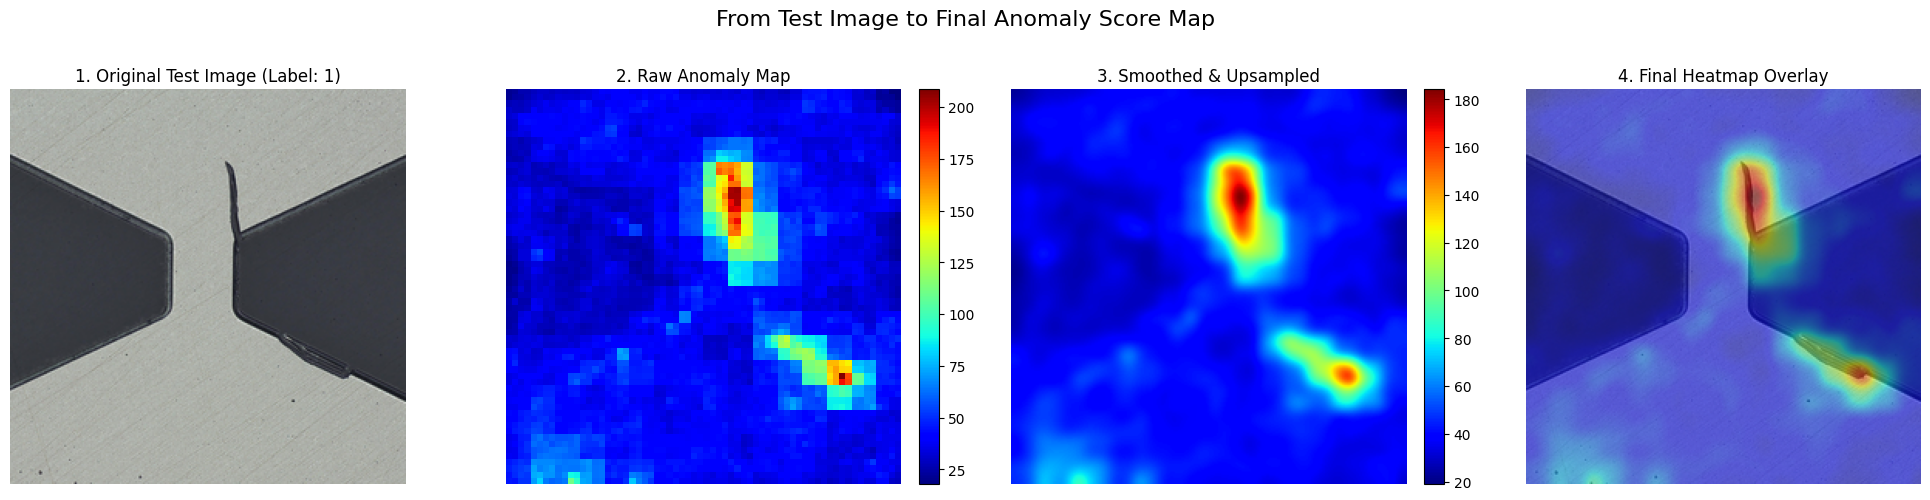

In [19]:
# --- 6-9. Visualize the Anomaly Map Generation Pipeline ---
print("\n--- Visualization 6-9: The Full Anomaly Scoring Pipeline ---")

# Let's find an anomalous image to visualize, if one exists in the batch
# Find the index of the first true anomaly in our test set
try:
    anomaly_index = list(ground_truth_labels).index(1)
    print(f"Visualizing a known anomalous image at index {anomaly_index}.")
except ValueError:
    anomaly_index = 0 # Default to the first image if no anomalies are in the batch
    print("No anomalies in this batch, visualizing the first image.")

# The 'anomaly_maps_raw' variable holds the map before upsampling
raw_anomaly_map = anomaly_maps_raw[anomaly_index]

# The 'score_maps' variable holds the upsampled and smoothed map
final_anomaly_map = score_maps[anomaly_index]

# The 'normalized_scores' is the final version
normalized_anomaly_map = normalized_scores[anomaly_index]

# Get the original test image for comparison
original_test_image = test_images_list[anomaly_index]

# Create the plot
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("From Test Image to Final Anomaly Score Map", fontsize=16)

# 1. Original Test Image
axes[0].imshow(denormalize_image_for_display(original_test_image))
axes[0].set_title(f"1. Original Test Image (Label: {ground_truth_labels[anomaly_index]})")
axes[0].axis('off')

# 2. Raw Anomaly Map (Mahalanobis Distances)
im1 = axes[1].imshow(raw_anomaly_map, cmap='jet')
axes[1].set_title("2. Raw Anomaly Map")
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3. Smoothed & Upsampled Anomaly Map
im2 = axes[2].imshow(final_anomaly_map, cmap='jet')
axes[2].set_title("3. Smoothed & Upsampled")
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

# 4. Final Heatmap Overlay
axes[3].imshow(denormalize_image_for_display(original_test_image))
axes[3].imshow(normalized_anomaly_map, cmap='jet', alpha=0.5)
axes[3].set_title("4. Final Heatmap Overlay")
axes[3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

In [143]:
import math
import json

--- Image 75 ---
  SUMMARY: Found 2 blobs.
    - Mean Area (px): 1638.00
    - Mean Intensity: 0.457
    - Quadrant Counts: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 1}


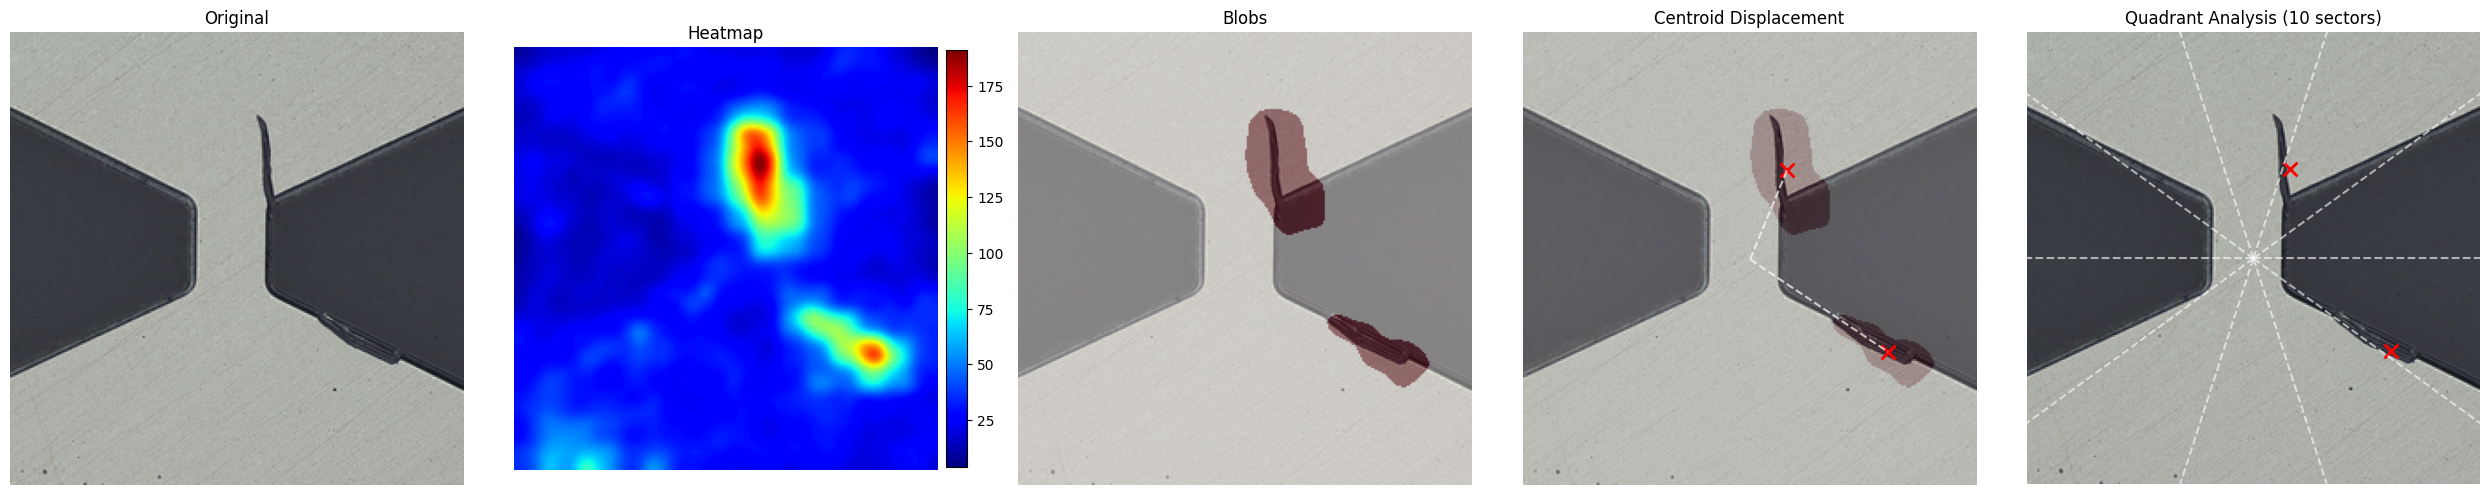

In [153]:
# --- Helper Function to Determine Quadrant ---
def get_quadrant(x, y, center_x, center_y, num_quadrants):
    """Calculates which quadrant a point (x, y) falls into."""
    # Calculate the angle of the point relative to the center
    angle = math.degrees(math.atan2(center_y - y, x - center_x))
    # Ensure angle is in the range [0, 360)
    if angle < 0:
        angle += 360
    
    # Calculate the size of each quadrant in degrees
    quadrant_size = 360 / num_quadrants
    
    # Determine the quadrant
    quadrant = int(angle // quadrant_size)
    return quadrant

# --- Main Loop ---
all_images_blob_data = []
all_images_summary_stats = []

for idx in range(75, 76):
    # --- Parameters ---
    num_quadrants = 10  # <-- CONTROL THE NUMBER OF PIE CUTS HERE
    percentile = 95
    min_blob_area = 100
    morph_kernel_size = 3

    # --- Image and Center Setup ---
    scores = normalized_scores[idx]
    orig_img = denormalize_image_for_display(test_images_list[idx])
    img_height, img_width, _ = orig_img.shape
    img_center_x, img_center_y = img_width / 2, img_height / 2
    
    # --- Blob detection ---
    thresh_val = np.percentile(scores, percentile)
    mask = (scores >= thresh_val).astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # --- Feature Extraction with Quadrant Mapping ---
    blobs_in_image = []
    mask_filtered = np.zeros_like(mask)
    
    for label in range(1, num_labels):
        area = int(stats[label, cv2.CC_STAT_AREA])
        if area >= min_blob_area:
            mask_filtered[labels == label] = 255
            blob_coords = np.where(labels == label)
            blob_scores = scores[blob_coords]
            
            total_intensity = np.sum(blob_scores)
            weighted_y = np.sum(blob_coords[0] * blob_scores) / total_intensity
            weighted_x = np.sum(blob_coords[1] * blob_scores) / total_intensity
            
            # Get quadrant for the weighted centroid
            quadrant = get_quadrant(weighted_x, weighted_y, img_center_x, img_center_y, num_quadrants)
            
            blobs_in_image.append({
                'label': label, 'area': area,
                'mean_intensity': np.mean(blob_scores), 'max_intensity': np.max(blob_scores),
                'weighted_centroid': (weighted_x, weighted_y),
                'quadrant': quadrant  # Add quadrant data to the blob
            })

    all_images_blob_data.append(blobs_in_image)

    # --- Aggregate stats calculation ---
    image_summary = {}
    if blobs_in_image:
        # Calculate quadrant counts
        quadrant_counts = {i: 0 for i in range(num_quadrants)}
        for blob in blobs_in_image:
            quadrant_counts[blob['quadrant']] += 1

        all_areas = [b['area'] for b in blobs_in_image]
        all_mean_intensities = [b['mean_intensity'] for b in blobs_in_image]
        image_summary = {
            'image_idx': idx, 'blob_count': len(blobs_in_image),
            'mean_area': np.mean(all_areas), 'mean_intensity': np.mean(all_mean_intensities),
            'quadrant_counts': quadrant_counts # Add quadrant summary
        }
    else:
        image_summary = {
            'image_idx': idx, 'blob_count': 0, 'mean_area': 0, 'mean_intensity': 0,
            'quadrant_counts': {i: 0 for i in range(num_quadrants)}
        }
    all_images_summary_stats.append(image_summary)

    # --- Visualization ---
    print(f"--- Image {idx} ---")
    if image_summary['blob_count'] > 0:
        print(f"  SUMMARY: Found {image_summary['blob_count']} blobs.")
        print(f"    - Mean Area (px): {image_summary['mean_area']:.2f}")
        print(f"    - Mean Intensity: {image_summary['mean_intensity']:.3f}")
        print(f"    - Quadrant Counts: {image_summary['quadrant_counts']}")
    else:
        print("  SUMMARY: No blobs found.")

    heatmap = (scores * 255).astype(np.uint8)
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    
    axes[0].imshow(orig_img); axes[0].set_title("Original"); axes[0].axis("off")
    im = axes[1].imshow(heatmap, cmap="jet"); axes[1].set_title("Heatmap"); axes[1].axis("off")
    fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.02)
    axes[2].imshow(orig_img); axes[2].imshow(mask_filtered, cmap="Reds", alpha=0.4); axes[2].set_title("Blobs"); axes[2].axis("off")
    axes[3].imshow(orig_img); axes[3].set_title("Centroid Displacement"); axes[3].axis("off")
    
    # --- Centroid Displacement Plot ---
    if blobs_in_image:
        for blob in blobs_in_image:
            x, y = blob['weighted_centroid']
            axes[3].imshow(mask_filtered, cmap="Reds", alpha=0.1)
            axes[3].plot([img_center_x, x], [img_center_y, y], 'w--', alpha=0.7)
            axes[3].scatter(x, y, marker='x', color='red', s=100, linewidths=2)
            
    # --- NEW: Quadrant Analysis Plot ---
    axes[4].imshow(orig_img); axes[4].set_title(f"Quadrant Analysis ({num_quadrants} sectors)"); axes[4].axis("off")
    
    # Draw quadrant lines
    for i in range(num_quadrants):
        angle = (360 / num_quadrants) * i
        rad_angle = math.radians(angle)
    #     # Draw a long line that will definitely cross the image boundary
        end_x = img_center_x + img_width * math.cos(rad_angle)
        end_y = img_center_y - img_height * math.sin(rad_angle) # Y is inverted in image coords
        axes[4].plot([img_center_x, end_x], [img_center_y, end_y], 'w--', alpha=0.6)

    axes[4].set_xlim(0, img_width)
    axes[4].set_ylim(img_height, 0)

    # Plot centroids and label with their quadrant number
    if blobs_in_image:
        for blob in blobs_in_image:
            x, y = blob['weighted_centroid']
            quadrant = blob['quadrant']
            axes[4].scatter(x, y, marker='x', color='red', s=100, linewidths=2)

    plt.tight_layout()
    plt.show()

In [155]:
len(ground_truth_labels)

108

In [158]:
# --- Main Loop ---
# This is now the primary data structure to hold everything.
analysis_results = []

for idx in range(0, len(ground_truth_labels)):
    # --- Parameters ---
    num_quadrants = 10
    percentile = 95
    min_blob_area = 100
    morph_kernel_size = 3

    # --- Image and Center Setup ---
    # Assuming test_dataset.x[idx] holds the full path to the image file
    image_path = test_filepaths[idx]
    image_filename = os.path.basename(image_path)
    
    scores = normalized_scores[idx]
    orig_img = denormalize_image_for_display(test_images_list[idx])
    img_height, img_width, _ = orig_img.shape
    img_center_x, img_center_y = img_width / 2, img_height / 2
    
    # --- Blob detection (same as before) ---
    thresh_val = np.percentile(scores, percentile)
    mask = (scores >= thresh_val).astype(np.uint8) * 255
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    # --- ENRICHED Feature Extraction ---
    blobs_in_image = []
    mask_filtered = np.zeros_like(mask)
    
    for label in range(1, num_labels):
        area = int(stats[label, cv2.CC_STAT_AREA])
        if area >= min_blob_area:
            mask_filtered[labels == label] = 255
            
            # Bounding box info from stats array
            bbox_x = int(stats[label, cv2.CC_STAT_LEFT])
            bbox_y = int(stats[label, cv2.CC_STAT_TOP])
            bbox_w = int(stats[label, cv2.CC_STAT_WIDTH])
            bbox_h = int(stats[label, cv2.CC_STAT_HEIGHT])
            
            blob_coords = np.where(labels == label)
            blob_scores = scores[blob_coords]
            
            total_intensity = np.sum(blob_scores)
            weighted_y = np.sum(blob_coords[0] * blob_scores) / total_intensity
            weighted_x = np.sum(blob_coords[1] * blob_scores) / total_intensity
            
            quadrant = get_quadrant(weighted_x, weighted_y, img_center_x, img_center_y, num_quadrants)
            
            # Distance from image center
            distance = math.sqrt((weighted_x - img_center_x)**2 + (weighted_y - img_center_y)**2)

            blobs_in_image.append({
                'image_filename': image_filename,
                'blob_label': label,
                'area_pixels': area,
                'bounding_box': {'x': bbox_x, 'y': bbox_y, 'width': bbox_w, 'height': bbox_h},
                'mean_intensity': np.mean(blob_scores),
                'max_intensity': np.max(blob_scores),
                'geometric_centroid': (centroids[label][0], centroids[label][1]), # Simple center
                'weighted_centroid': (weighted_x, weighted_y), # Center of mass
                'distance_from_center': distance,
                'quadrant': quadrant
})

    # --- Aggregate stats calculation ---
    image_summary = {}
    if blobs_in_image:
        quadrant_counts = {i: 0 for i in range(num_quadrants)}
        for blob in blobs_in_image:
            quadrant_counts[blob['quadrant']] += 1
        
        image_summary = {
            'image_idx': idx,
            'image_gt_label': int(ground_truth_labels[idx]),
            'image_filename': image_filename,
            'blob_count': len(blobs_in_image),
            'mean_area': np.mean([b['area_pixels'] for b in blobs_in_image]),
            'mean_intensity': np.mean([b['mean_intensity'] for b in blobs_in_image]),
            'mean_dist_from_center': np.mean([b['distance_from_center'] for b in blobs_in_image]),
            'quadrant_counts': quadrant_counts,
            'blobs': blobs_in_image  # Nest the detailed blob data inside the summary
        }
    else:
        image_summary = {
            'image_idx': idx, 'image_filename': image_filename, 'blob_count': 0,
            'blobs': [] # Still include an empty list
        }
    
    analysis_results.append(image_summary)

In [160]:
import csv

In [161]:
# --- NEW: Exporting All Blob Data to a CSV File ---
# After the loop, this block will create a single CSV with all the detailed data.
output_csv_filename = 'blob_analysis.csv'
# Flatten the data: Create a single list of all blobs from all images
all_blobs_flat = []
for image_data in analysis_results:
    all_blobs_flat.extend(image_data['blobs'])

if all_blobs_flat:
    # Define the headers for the CSV file based on the keys in the blob dictionaries
    headers = all_blobs_flat[0].keys()

    with open(output_csv_filename, 'w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()  # Write the column titles
        writer.writerows(all_blobs_flat) # Write all blob data

    print(f"\n✅ Successfully saved detailed analysis for {len(all_blobs_flat)} blobs to '{output_csv_filename}'")
else:
    print("\nNo blobs were found to save to CSV.")


✅ Successfully saved detailed analysis for 621 blobs to 'blob_analysis.csv'


In [100]:
# --- Calculate and Display Mean Anomaly Maps ---
print("\n--- Visualization: Calculating and displaying mean anomaly maps ---")

# --- 1. Separate the anomaly maps based on their ground truth label ---
normal_indices = np.where(ground_truth_labels == 0)[0]
anomalous_indices = np.where(ground_truth_labels == 1)[0]

# --- 2. Calculate the mean of each group of maps ---
# Initialize with zeros in case a category has no images
mean_raw_normal = np.zeros_like(anomaly_maps_raw[0])
mean_upscaled_normal = np.zeros_like(score_maps[0])
mean_raw_anomalous = np.zeros_like(anomaly_maps_raw[0])
mean_upscaled_anomalous = np.zeros_like(score_maps[0])


--- Visualization: Calculating and displaying mean anomaly maps ---


Calculated mean maps for 75 normal images.
Calculated mean maps for 33 anomalous images.

Mean anomaly map comparison plot saved to: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1/mean_anomaly_maps_comparison.png


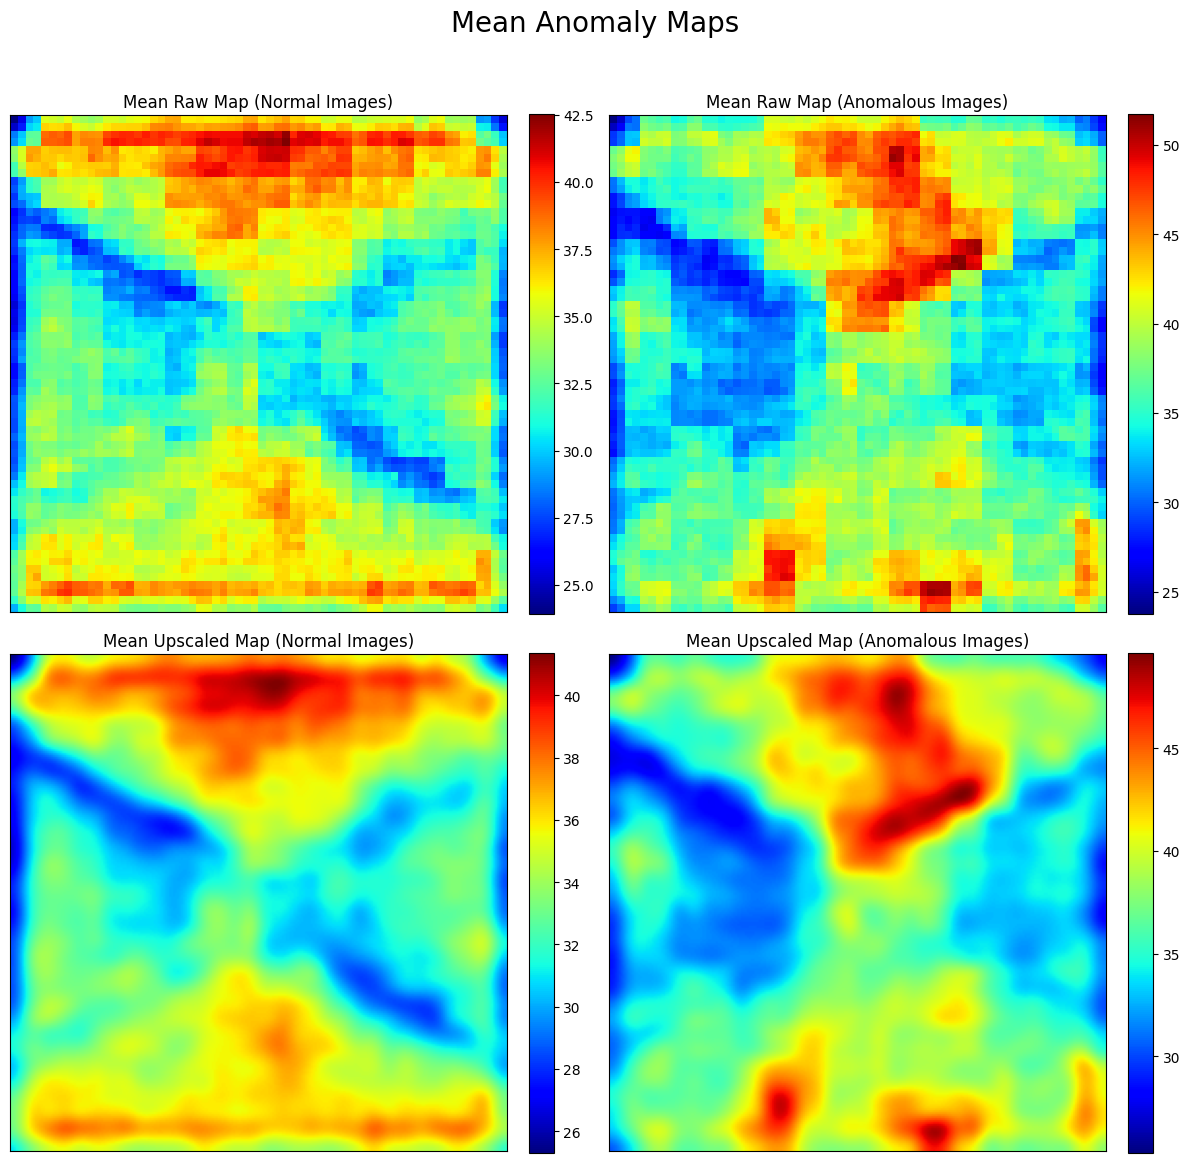

In [101]:
# Calculate means if images for the category exist
if len(normal_indices) > 0:
    mean_raw_normal = np.mean(anomaly_maps_raw[normal_indices], axis=0)
    mean_upscaled_normal = np.mean(score_maps[normal_indices], axis=0)
    print(f"Calculated mean maps for {len(normal_indices)} normal images.")
else:
    print("No normal images found in the test set to create a mean map.")

if len(anomalous_indices) > 0:
    mean_raw_anomalous = np.mean(anomaly_maps_raw[anomalous_indices], axis=0)
    mean_upscaled_anomalous = np.mean(score_maps[anomalous_indices], axis=0)
    print(f"Calculated mean maps for {len(anomalous_indices)} anomalous images.")
else:
    print("No anomalous images found in the test set to create a mean map.")


# --- 3. Create the 2x2 plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("Mean Anomaly Maps", fontsize=20)

# --- Top Row: Raw (Non-upscaled) Maps ---
# Good/Normal
im1 = axes[0, 0].imshow(mean_raw_normal, cmap='jet')
axes[0, 0].set_title("Mean Raw Map (Normal Images)")
axes[0, 0].axes.xaxis.set_visible(False)
axes[0, 0].axes.yaxis.set_visible(False)
fig.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)

# Bad/Anomalous
im2 = axes[0, 1].imshow(mean_raw_anomalous, cmap='jet')
axes[0, 1].set_title("Mean Raw Map (Anomalous Images)")
axes[0, 1].axes.xaxis.set_visible(False)
axes[0, 1].axes.yaxis.set_visible(False)
fig.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)

# --- Bottom Row: Upscaled Maps ---
# Good/Normal
im3 = axes[1, 0].imshow(mean_upscaled_normal, cmap='jet')
axes[1, 0].set_title("Mean Upscaled Map (Normal Images)")
axes[1, 0].axes.xaxis.set_visible(False)
axes[1, 0].axes.yaxis.set_visible(False)
fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

# Bad/Anomalous
im4 = axes[1, 1].imshow(mean_upscaled_anomalous, cmap='jet')
axes[1, 1].set_title("Mean Upscaled Map (Anomalous Images)")
axes[1, 1].axes.xaxis.set_visible(False)
axes[1, 1].axes.yaxis.set_visible(False)
fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)


# --- Save and Show Plot ---
mean_maps_path = os.path.join(CLASS_SAVE_DIR, "mean_anomaly_maps_comparison.png")
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.savefig(mean_maps_path)
print(f"\nMean anomaly map comparison plot saved to: {mean_maps_path}")
plt.show()

In [102]:
# --- 1. Find the Optimal Threshold from the ROC Curve ---
# The roc_curve function returns fpr, tpr, and the thresholds it used to calculate them
# We rename the third output from '_' to 'thresholds' for clarity
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    ground_truth_labels, image_level_anomaly_scores
)

# Calculate the G-Mean for each threshold. The G-Mean is a good metric for imbalanced data.
# It measures the balance between sensitivity (TPR) and specificity (1 - FPR).
gmeans = np.sqrt(true_positive_rate * (1 - false_positive_rate))

# Locate the index of the largest G-Mean
best_gmean_index = np.argmax(gmeans)
optimal_threshold = thresholds[best_gmean_index]

print(f"--- Confusion Matrix Analysis ---")
print(f"Best Threshold found: {optimal_threshold:.4f}")
print(f"  At this threshold:")
print(f"  - True Positive Rate (Sensitivity): {true_positive_rate[best_gmean_index]:.4f}")
print(f"  - False Positive Rate: {false_positive_rate[best_gmean_index]:.4f}")


--- Confusion Matrix Analysis ---
Best Threshold found: 0.3318
  At this threshold:
  - True Positive Rate (Sensitivity): 0.9091
  - False Positive Rate: 0.1200



Confusion Matrix:
  - True Negatives (Correctly Normal): 66
  - False Positives (Normal as Anomaly): 9
  - False Negatives (Anomaly as Normal): 3
  - True Positives (Correctly Anomaly): 30

Confusion matrix plot saved to: ./results/wide_resnet50_2_resize-256_crop-256/color_profile_1/confusion_matrix.png


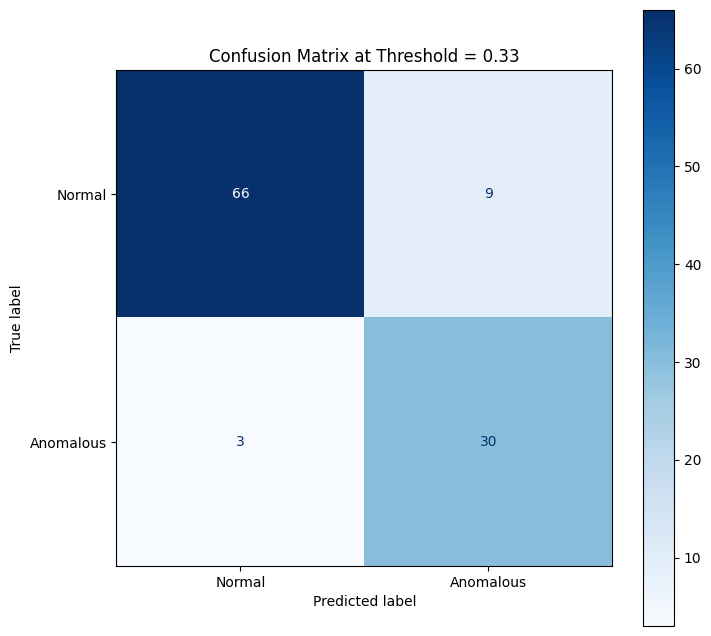

In [103]:
# --- 2. Apply Threshold to Get Predictions ---
# Convert continuous scores to binary predictions using the optimal threshold
predictions = (image_level_anomaly_scores >= optimal_threshold).astype(int)


# --- 3. Calculate and Plot the Confusion Matrix ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(ground_truth_labels, predictions)

print("\nConfusion Matrix:")
print(f"  - True Negatives (Correctly Normal): {cm[0, 0]}")
print(f"  - False Positives (Normal as Anomaly): {cm[0, 1]}")
print(f"  - False Negatives (Anomaly as Normal): {cm[1, 0]}")
print(f"  - True Positives (Correctly Anomaly): {cm[1, 1]}")


# Plot the visual confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomalous'])
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='g')
plt.title(f"Confusion Matrix at Threshold = {optimal_threshold:.2f}")

# Save and show the plot
cm_path = os.path.join(CLASS_SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path)
print(f"\nConfusion matrix plot saved to: {cm_path}")
plt.show()
